# 🔥 Fire Scope: Fire Image Detection with CNN and Transfer Learning (98% acc)

Alright! In this project, we'll be looking into the steps of performing image classification. This is my first project using *PyTorch* and on *computer vision*, so please feel free to make suggestions and recommendations on how this notebook can be improved. Without further ado, let's jump in!

# Objective

In this project, we have a dataset that contains two types of images: *fire images* and *non-fire images*. Our objective is to be able to classify these images into their corresponding categories. To complete this task, we'll be building two of our own **convolutional neural network (CNN)**, a simple one and a slightly more complicated one. At the very end, we'll compare the performance of our model to a **pretrained model** and see for ourselves the incredible power of transfer learning. Let's begin.

# Setup

First, let's start by importing the modules used in this notebook, and we'll also set our random seed for reproducibility.

In [1]:
#import modules
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchinfo import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import os
from pathlib import Path
from tqdm.auto import tqdm
import random
import math

#set random seed for reproducibility
seed = 42

Here is the PyTorch version that is used in this notebook.

In [2]:
#check PyTorch version
torch.__version__

'1.13.0'

Whenever we would like to train with a GPU, it's always a good habit to setup the **device-agnostic code**. The **device-agnostic code** is essentially the code that specifies which computing device to use based on availability. So we can see that in the code below, we hope to set our device as `cuda` (which stands for GPU) whenever a GPU is available. If a GPU is not available, we can only set our device as `cpu`.

In [3]:
# # Setup device-agnostic code for nvidia gpu
# device = "cuda" if torch.cuda.is_available() else "cpu"
# device

But since I'm currently using a mac with apple silicon (M2 Pro), the device-agnostic code will be slightly different.

In [4]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

# Dataset

Next, let's take a look at our data. First, let's define a function that allows us to walk through and identify the number of images in each folder. 

In [6]:
#define function that walks through each directory and subdirectory
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir("../data")

There are 2 directories and 0 images in '../data'.
There are 0 directories and 244 images in '../data/non_fire_images'.
There are 0 directories and 755 images in '../data/fire_images'.


We can see that we have 999 total images placed in two different folders. Let's setup the path to these two folders first.

In [7]:
#setup path for our data files
fire_dir = Path("../data/fire_images")
non_fire_dir = Path("../data/non_fire_images")

fire_dir, non_fire_dir

(PosixPath('../data/fire_images'), PosixPath('../data/non_fire_images'))

Now that we have access to the folders, let's randomly select one image from each folder and visualize it.

Random image path: ../data/fire_images/fire.639.png
Image class: fire_images
Image height: 600
Image width: 800


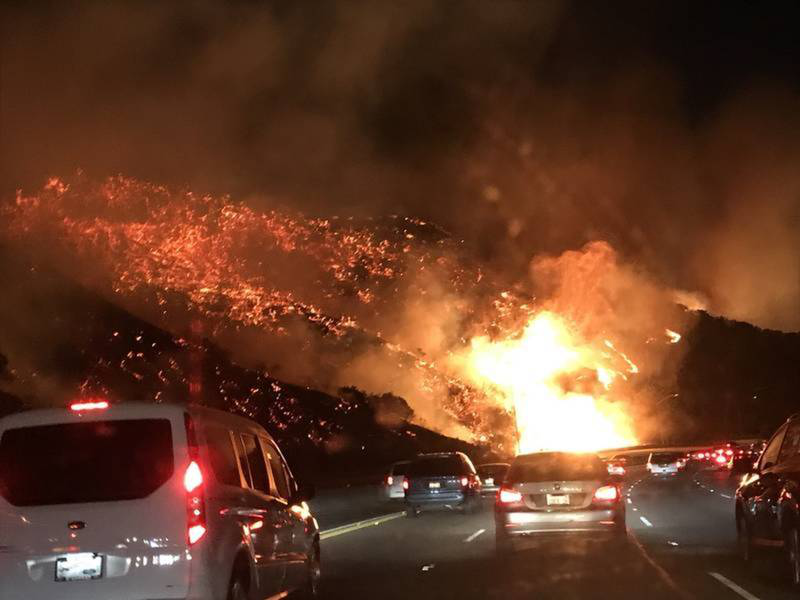

In [8]:
#set seed
random.seed(seed)

#get all image paths from the fire file (* means "any combination")
fire_image_list = list(fire_dir.glob("*.*.png"))

#get random image path
random_fire_image_path = random.choice(fire_image_list)

#get image class from path name
fire_image_class = random_fire_image_path.parent.stem

#open image
img = Image.open(random_fire_image_path)

print(f"Random image path: {random_fire_image_path}")
print(f"Image class: {fire_image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Wow! The fire in this image is crazy! Now what about the non-fire images?

Random image path: ../data/non_fire_images/non_fire.203.png
Image class: non_fire_images
Image height: 685
Image width: 1024


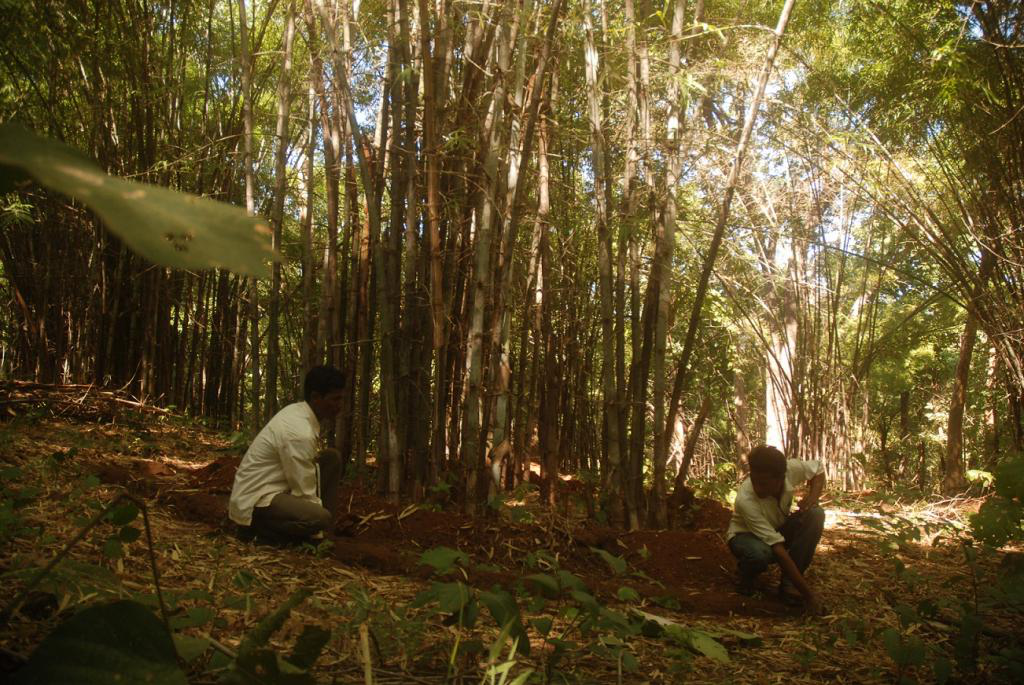

In [9]:
random.seed(seed)

#get all image paths from the non-fire file (* means "any combination")
non_fire_image_list = list(non_fire_dir.glob("*.*.png"))

random_non_fire_image_path = random.choice(non_fire_image_list)
non_fire_image_class = random_non_fire_image_path.parent.stem
img = Image.open(random_non_fire_image_path)

print(f"Random image path: {random_non_fire_image_path}")
print(f"Image class: {non_fire_image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

Oof! From the human eyes, we can see that there is indeed no fire in the image. But the brighter spots may be tricky for the computer to categorize. Anyways, now that we've made sure there's nothing wrong in the images, let's proceed to our next step.

# Data Transformation

In our next step, we have to transform our images into **tensors** so that it can be fed into our models. There are also plenty of other transformations we can apply to our images in `torchvision.transforms` for **data augmentation**. In our case, let's just keep it simple by randomizing the transformation. `TrivialAugmentWide` essentially applies one random transformation to each image. The magnitude of transformation is also randomized to the extent set by its `num_magnitude_bins` parameter. Keeping the transformation completely random is said to perform better than handpicking the transformation.

In [10]:
#transforms.Compose allows us to package all of the transformations we want to perform on the image
data_transform = transforms.Compose([
    #resize the images to 128x128
    transforms.Resize(size=(128, 128)),
    #randomly pick a transformation with a random magnitude and apply one transformation to one image
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    #turn the image into a torch.Tensor and also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.ToTensor() 
])

We can visualize what the transformation does to the two images presented just now. The size and datatype is clearly modified, and although the `TrivialAugmentWide` transformation isn't particularly apparent, you can trust me that the pictures have encountered some type of transformation.

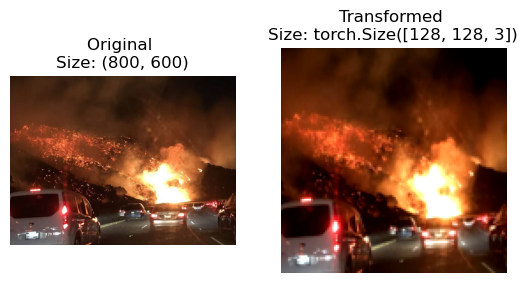

In [11]:
with Image.open(random_fire_image_path) as f:
    
    #before transformation
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    #after transformation
    #PyTorch default is [C, H, W] but Matplotlib is [H, W, C]
    torch.manual_seed(seed)
    transformed_image = data_transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

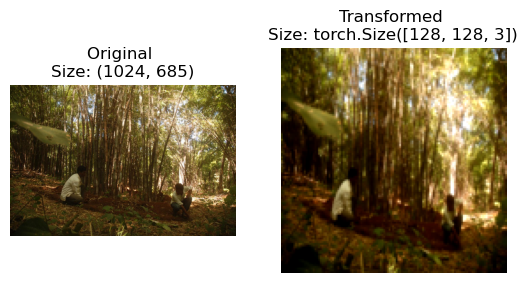

In [12]:
with Image.open(random_non_fire_image_path) as f:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    torch.manual_seed(seed)
    transformed_image = data_transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

Now that we have defined our data transformation, let's setup our data so that we can apply the transformation to it. We feed the root directory of our dataset into the `ImageFolder` method.

In [13]:
#define data root directory
root_dir = "../data"

#you can also apply data transformation using the `transforms` parameter here
fire_dataset = ImageFolder(root_dir)

The `ImageFolder` method automatically looks into the root directly and assigns the classes by the folder name. So in the root directory that we fed into the function, it contains two folders *fire_images* and *non_fire_images*. These two folder names will automatically be assigned as the two classes. This is also when you typically apply the transformation using the `transform` argument, but since we only want to apply the transformation to the training and validation dataset, let's not rush to transform our data.

In [14]:
#the classes are the names of the files in the root folder
class_names = fire_dataset.classes
class_names

['fire_images', 'non_fire_images']

In [15]:
#class names as a dict
class_dict = fire_dataset.class_to_idx
class_dict

{'fire_images': 0, 'non_fire_images': 1}

Once we have defined our dataset, we can split it into training, validation and training using `random_split`.

In [16]:
#split the dataset into training, validation and testing
train_dataset, valid_dataset, test_dataset = random_split(fire_dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

In [17]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(700, 150, 149)

Now that we have our training, validation and testing dataset seperated, we can apply the data transformation specifically towards the training and validation dataset. But to do so, we have to define our own `MySubset` class, which replicates the functionality of `ImageFolder`, with only a small modification.

In [18]:
#define custom data subset
class MySubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        
        #if a transform argument is provided, apply the transformaiton to the subset
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [19]:
#apply data transformation only to the training and validation dataset
train_dataset = MySubset(train_dataset, transform=data_transform)
valid_dataset = MySubset(valid_dataset, transform=data_transform)

Perfect! Our training and validation datasets are transformed. We can now use `DataLoader` to load our data into **batches** that can be fed into our neural network.

In [20]:
#use DataLoader to load and group dataset into batches
batch_size = 32

torch.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

torch.manual_seed(seed)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

We can see below that in each batch of data, we have 32 samples of images with dimensions 3 * 128 * 128.

In [21]:
#check that each batch contains 32 samples of images
img, label = next(iter(train_loader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


# Baseline Model

Our data is ready to be fed into a model, so let's just define a small and simple convolutional neural network as our baseline model. We can see below that our baseline model simply consists of a few layers. 

1. Convolutional Layer
2. ReLU activation Function
3. Convolutional Layer
4. ReLU activation function
5. MaxPooling Layer
6. Flatten and Classifier Layer

You may adjust the parameters to your liking, but remember that this is just a baseline model. We'll see how a simple CNN can cope with our dataset.

**Note**: You might have noticed that in the linear layer of the classifier, we set `in_features=17640`. It's usually very troublesome to calculate this number, so the best way to calculate this is by simply feeding in a random image to the model `model(img)`. The returned error will tell you the number of `in_features` precisely.

In [22]:
#define architecture for our baseline CNN model
class Baseline(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            #first convolution layer
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #second convolution layer
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            #pooling layer
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            #we can find the number of layers checking the summary from torchinfo (example below)
            nn.Linear(in_features=17640,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        
        return self.classifier(self.conv_block_1(x)) #leverage the benefits of operator fusion

Let's instantiate the model, which takes in arguments `input_shape`, `hidden_units` and `output_shape`. The `hidden_units`, again, can be adjusted to your liking.

In [23]:
torch.manual_seed(seed)
#instantiate baseline model
baseline = Baseline(input_shape=3,
                  hidden_units=10, 
                  output_shape=1)
baseline

Baseline(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=17640, out_features=1, bias=True)
  )
)

We can even see the number of parameters and output shape of each layer in our baseline model using the `summary()` method from `torchinfo`. This will also confirm that the output shape of the flatten layer is indeed 17640. Pretty cool right! 

In [24]:
#see the outputs by feeding in a test pass
summary(baseline, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
Baseline                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 10, 42, 42]          --
│    └─Conv2d: 2-1                       [32, 10, 128, 128]        280
│    └─ReLU: 2-2                         [32, 10, 128, 128]        --
│    └─Conv2d: 2-3                       [32, 10, 128, 128]        910
│    └─ReLU: 2-4                         [32, 10, 128, 128]        --
│    └─MaxPool2d: 2-5                    [32, 10, 42, 42]          --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Flatten: 2-6                      [32, 17640]               --
│    └─Linear: 2-7                       [32, 1]                   17,641
Total params: 18,831
Trainable params: 18,831
Non-trainable params: 0
Total mult-adds (M): 624.47
Input size (MB): 6.29
Forward/backward pass size (MB): 83.89
Params size (MB): 0.08
Estimated Total Size (MB): 90.25

Next, let's define our training step. The function below will allow us to train the model and record the loss and accuracy.

In [25]:
#define function for training and evaluating each epoch
def train_per_epoch(model, train_dataloader, test_dataloader, loss_fn, optimizer):

    model.train() 
    train_loss, train_acc = 0, 0
    
    #loop through data loader data batches

    for batch, (X, y) in enumerate(train_dataloader):
        
        X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)
        
        #make prediction
        y_logits = model(X)
        y_pred = torch.round(torch.sigmoid(y_logits))
        
        #calculate and accumulate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        
        #calculate and accumulate accuracy
        acc = (y_pred == y).sum().item()/len(y)
        train_acc += acc
        
        #update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Calculate the average loss and average acc by batch (in one epoch)
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)

    ### Testing Loop
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():

        for batch, (X, y) in enumerate(test_dataloader):

            X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)

            test_logits = model(X)
            test_pred = torch.round(torch.sigmoid(test_logits))

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            #calculate and accumulate accuracy
            acc = (test_pred == y).sum().item()/len(y)
            test_acc += acc
            
    #Calculate the average loss and average acc by batch (in one epoch)
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    return train_loss, train_acc, test_loss, test_acc

We should also replicate `ModelCheckpoint` by defining a function that records down the best model (with the lowest loss) during training. The `checkpoint` function will save the model's parameters, while the `resume` function will allow us to load the saved parameters. 

In [26]:
#setup ModelCheckpoint
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    
def resume(model, filename):
    model.load_state_dict(torch.load(filename))

Now we can put everything altogether and define the `train` functions which primarily loops through the number of epochs requested. `EarlyStopping` and `ModelCheckpoint` are also included as part of the function.

In [27]:
#define train function
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, best_model_path):
    
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    #setup early stopping and model checkpoint
    early_stop_threshold = 10
    best_loss = float("inf")
    best_epoch = -1
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc, test_loss, test_acc = train_per_epoch(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        
        print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

        #update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        #EarlyStopping and ModelCheckpoint
        if test_loss < best_loss:
            best_loss = test_loss
            best_epoch = epoch
            checkpoint(model, best_model_path)
        elif epoch - best_epoch > early_stop_threshold:
            print("Early stopped training at epoch %d" % epoch+1)
            break  # terminate the training loop
    
    print(f"Epoch with best loss: Epoch {best_epoch+1} at {best_loss:.4f}")

    return results

Finally, we can define our loss function and optimizer, and train the model.

In [28]:
#set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

#loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=baseline.parameters(), lr=0.001)

#train baseline model
baseline_results = train(model=baseline.to(device), train_dataloader=train_loader, test_dataloader=valid_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, best_model_path = "best_baseline_model.pth")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5353 | train_acc: 0.7539 | test_loss: 0.4050 | test_acc: 0.7761
Epoch: 2 | train_loss: 0.3675 | train_acc: 0.8249 | test_loss: 0.2473 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.2519 | train_acc: 0.8959 | test_loss: 0.2118 | test_acc: 0.9284
Epoch: 4 | train_loss: 0.2003 | train_acc: 0.9142 | test_loss: 0.2423 | test_acc: 0.9159
Epoch: 5 | train_loss: 0.1843 | train_acc: 0.9186 | test_loss: 0.2111 | test_acc: 0.9097
Epoch: 6 | train_loss: 0.2069 | train_acc: 0.9152 | test_loss: 0.1861 | test_acc: 0.9347
Epoch: 7 | train_loss: 0.1975 | train_acc: 0.9040 | test_loss: 0.2198 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.1759 | train_acc: 0.9203 | test_loss: 0.1797 | test_acc: 0.9284
Epoch: 9 | train_loss: 0.1667 | train_acc: 0.9300 | test_loss: 0.2222 | test_acc: 0.8972
Epoch: 10 | train_loss: 0.1686 | train_acc: 0.9324 | test_loss: 0.2938 | test_acc: 0.9222
Epoch with best loss: Epoch 8 at 0.1797


It appears that the baseline model did pretty well! During epoch 8, the test loss was around 0.18 with a test accuracy of about 92%. Not too bad for such a small and simple model. Let's define a function so we can better visualize this training process.

In [29]:
def plot_results(results):
    
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]
    test_loss = results["test_loss"]
    test_acc = results["test_acc"]
    
    epochs = range(len(results['train_loss']))
    
    plt.figure(figsize=(10, 5))
    
    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

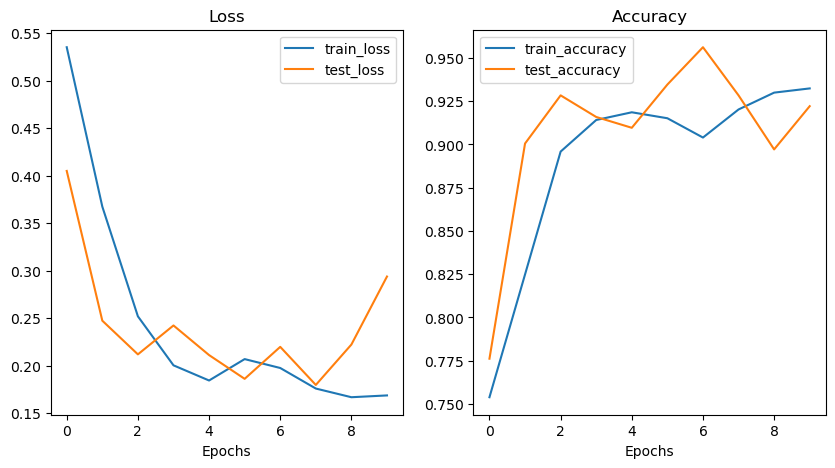

In [30]:
plot_results(baseline_results)

The loss and accuracy curves look great! We can see that there was a surge in test loss at the very end. This could be an indication that the model is overfitting towards the end. But that should be no big deal, since our `ModelCheckpoint` saved the best model at epoch 8 (epoch 7 in the graph above). In the accuracy curve, we also observed quite a large fluctuation. Perhaps, we need to adjust the learning rate lower and increase the number of epochs to stablize the learning process.

# Slightly More Complicated Model

Awesome! The baseline model has already demonstrated some promising results. Let's experiment with a slightly more complicated model. In this slightly more complicated model, let's add some additional layers and normalization.

In [31]:
#define slightly more complicated model
class SlightlyMoreComplicated(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        
        #first convolution block
        self.conv_block_1 = nn.Sequential(

            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),

            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(hidden_units),
            nn.BatchNorm2d(hidden_units),

            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        
        #second convolution block
        self.conv_block_2 = nn.Sequential(

            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),

            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_units),

            nn.MaxPool2d(kernel_size=3, stride=3)
        )
        
        #final classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=3136,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Let's also increase the number of `hidden_units=16`.

In [32]:
torch.manual_seed(seed)
#instantiate model_1
model_1 = SlightlyMoreComplicated(input_shape=3, hidden_units=16, output_shape=1)
model_1

SlightlyMoreComplicated(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (class

In [33]:
summary(model_1, input_size=[32, 3, 128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
SlightlyMoreComplicated                  [32, 1]                   --
├─Sequential: 1-1                        [32, 16, 42, 42]          --
│    └─Conv2d: 2-1                       [32, 16, 128, 128]        448
│    └─ReLU: 2-2                         [32, 16, 128, 128]        --
│    └─BatchNorm2d: 2-3                  [32, 16, 128, 128]        32
│    └─Conv2d: 2-4                       [32, 16, 128, 128]        2,320
│    └─ReLU: 2-5                         [32, 16, 128, 128]        --
│    └─BatchNorm2d: 2-6                  [32, 16, 128, 128]        32
│    └─MaxPool2d: 2-7                    [32, 16, 42, 42]          --
├─Sequential: 1-2                        [32, 16, 14, 14]          --
│    └─Conv2d: 2-8                       [32, 16, 42, 42]          2,320
│    └─ReLU: 2-9                         [32, 16, 42, 42]          --
│    └─BatchNorm2d: 2-10                 [32, 16, 42, 42]          32
│    └─C

As mentioned before, we'll also increase the number of epochs and lower the learning rate to stabilize the learning process.

In [34]:
#set random seeds
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)

#increased number of epochs
NUM_EPOCHS = 25

#loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
#lower learning rate
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.00005)

#train model_1
model_1_results = train(model=model_1.to(device), train_dataloader=train_loader, test_dataloader=valid_loader, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, best_model_path = "best_model_1.pth")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5806 | train_acc: 0.6703 | test_loss: 0.7434 | test_acc: 0.2517
Epoch: 2 | train_loss: 0.4801 | train_acc: 0.7658 | test_loss: 0.4844 | test_acc: 0.7824
Epoch: 3 | train_loss: 0.4347 | train_acc: 0.7804 | test_loss: 0.3643 | test_acc: 0.8108
Epoch: 4 | train_loss: 0.3813 | train_acc: 0.8182 | test_loss: 0.3691 | test_acc: 0.8040
Epoch: 5 | train_loss: 0.3082 | train_acc: 0.8545 | test_loss: 0.2936 | test_acc: 0.8381
Epoch: 6 | train_loss: 0.3123 | train_acc: 0.8610 | test_loss: 0.2776 | test_acc: 0.8784
Epoch: 7 | train_loss: 0.2711 | train_acc: 0.8914 | test_loss: 0.2233 | test_acc: 0.9187
Epoch: 8 | train_loss: 0.2527 | train_acc: 0.8803 | test_loss: 0.2261 | test_acc: 0.9062
Epoch: 9 | train_loss: 0.2314 | train_acc: 0.9154 | test_loss: 0.2500 | test_acc: 0.8847
Epoch: 10 | train_loss: 0.2249 | train_acc: 0.9052 | test_loss: 0.2599 | test_acc: 0.8909
Epoch: 11 | train_loss: 0.2253 | train_acc: 0.9158 | test_loss: 0.3012 | test_acc: 0.8750
Epoch: 12 | train_l

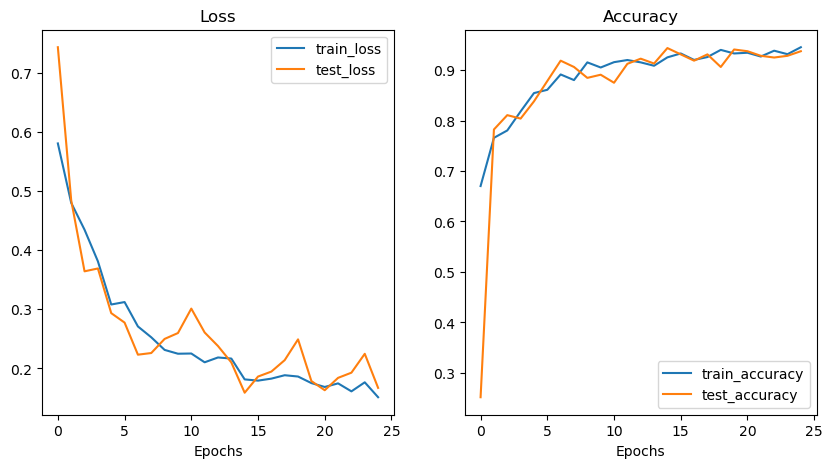

In [35]:
plot_results(model_1_results)

Wow! As expected, our slightly more complicated model returned a better result than the baseline model. A test loss of about 0.158 was achieved at Epoch 15, which is slightly lower than the lowest loss achieved in the baseline model. The accuracy curve was also a lot more stabilized. 

# Transfer Learning

Now, we could continue to experiment with other neural network architectures and try to add more depth and width to our network. But why waste the time when we have pretrained models available for use? Let's take a look and see if pre-trained models could exceed the performances of our two relatively simple models. 

## MobileNet_V3_Small

From `torchvision.models`, we could load different pretrained models and their parameters. In this case, let's select the *MobileNet_V3_Small* model.

In [36]:
#get a set of pretrained model weights
weights = models.MobileNet_V3_Small_Weights.DEFAULT
weights

MobileNet_V3_Small_Weights.IMAGENET1K_V1

PyTorch has also, very kindly, provided the required data transformation so that images can be fed into the model in the correct format.

In [37]:
#get the data transformations used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Just like what we did for the two previous models, let's prepare our data into the `DataLoader` so that it can be fed into the model.

In [38]:
root_dir = "../data"

fire_dataset_tl = ImageFolder(root_dir)

In [39]:
#random_split the dataset in training, validation and testing
train_dataset_tl, valid_dataset_tl, test_dataset_tl = random_split(fire_dataset_tl, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

In [40]:
#apply data transformation to the training and validation dataset
train_dataset_tl = MySubset(train_dataset_tl, transform=auto_transforms)
valid_dataset_tl = MySubset(valid_dataset_tl, transform=auto_transforms)

In [41]:
#load the data using DataLoader
batch_size = 32
train_loader_tl = DataLoader(train_dataset_tl, batch_size=batch_size, shuffle=True)
valid_loader_tl = DataLoader(valid_dataset_tl, batch_size=batch_size, shuffle=False)

After our data is processed, we can load the architecture for *MobileNet_V3_Small* and feed the weights into the model. We can see that, although this is only the small version of MobileNet, it is still significantly larger than the two models we built ourselves.

In [42]:
#load the weights into the model
model_tl = models.mobilenet_v3_small(weights=weights).to(device)
model_tl

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

The summary below shows that the this model contains 2.5 million parameters! It will probably take a long time to train with this model.

In [43]:
summary(model=model_tl, input_size=(32, 3, 384, 384))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [32, 1000]                --
├─Sequential: 1-1                                  [32, 576, 12, 12]         --
│    └─Conv2dNormActivation: 2-1                   [32, 16, 192, 192]        --
│    │    └─Conv2d: 3-1                            [32, 16, 192, 192]        432
│    │    └─BatchNorm2d: 3-2                       [32, 16, 192, 192]        32
│    │    └─Hardswish: 3-3                         [32, 16, 192, 192]        --
│    └─InvertedResidual: 2-2                       [32, 16, 96, 96]          --
│    │    └─Sequential: 3-4                        [32, 16, 96, 96]          744
│    └─InvertedResidual: 2-3                       [32, 24, 48, 48]          --
│    │    └─Sequential: 3-5                        [32, 24, 48, 48]          3,864
│    └─InvertedResidual: 2-4                       [32, 24, 48, 48]          --
│    │    └─Sequential: 3-6   

Thankfully, we won't have to train all 2.5 million parameters. The parameters in this model is already 'pretrained' (hence why it's a 'pretrained' model), so all we have to do is modify the last classifier layer so that the model would be able to perform our task here. We can see that the original `output_shape` is 1000 because this model was pretrained to classify 1000 different objects. But in our case, we're only classifying two objects, "fire" or "non-fire". So let's modify that!

## Freeze!

First, we'll freeze all of the parameters in the entire model by setting `param.requires_grad = False`.

In [44]:
#freeze all base layers in the pretrained model
for param in model_tl.features.parameters():
    param.requires_grad = False

And then we'll redefine the last classifier layer by changing the `out_features` in the last linear layer to 1.

In [45]:
#set the manual seeds
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#redefine classifier layer
model_tl.classifier = torch.nn.Sequential(
    nn.Linear(in_features=576, out_features=1024, bias=True),
    nn.Hardswish(),
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1024, out_features=1, bias=True)).to(device)

Let's take a look at our model summary again. We can see that the number of trainable parameters have been reduced significantly. Only the parameters in the final classifier layer will be updated

In [46]:
summary(model=model_tl, input_size=(32, 3, 384, 384))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [32, 1]                   --
├─Sequential: 1-1                                  [32, 576, 12, 12]         --
│    └─Conv2dNormActivation: 2-1                   [32, 16, 192, 192]        --
│    │    └─Conv2d: 3-1                            [32, 16, 192, 192]        (432)
│    │    └─BatchNorm2d: 3-2                       [32, 16, 192, 192]        (32)
│    │    └─Hardswish: 3-3                         [32, 16, 192, 192]        --
│    └─InvertedResidual: 2-2                       [32, 16, 96, 96]          --
│    │    └─Sequential: 3-4                        [32, 16, 96, 96]          (744)
│    └─InvertedResidual: 2-3                       [32, 24, 48, 48]          --
│    │    └─Sequential: 3-5                        [32, 24, 48, 48]          (3,864)
│    └─InvertedResidual: 2-4                       [32, 24, 48, 48]          --
│    │    └─Sequential

Our model is ready to be trained. Let's feed the data into the model!

In [47]:
#set random seeds
torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)

NUM_EPOCHS = 50

#loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_tl.parameters(), lr=0.0001)

#train model_tl
model_tl_results = train(model=model_tl.to(device), train_dataloader=train_loader_tl, test_dataloader=valid_loader_tl, optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, best_model_path = "best_model_tl.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

/Users/benchen/miniconda3/envs/firescope/lib/python3.8/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1670076299818/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)


Epoch: 1 | train_loss: 0.4883 | train_acc: 0.7597 | test_loss: 0.3888 | test_acc: 0.8938
Epoch: 2 | train_loss: 0.3332 | train_acc: 0.8462 | test_loss: 0.3122 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.2431 | train_acc: 0.9403 | test_loss: 0.2302 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.2016 | train_acc: 0.9487 | test_loss: 0.1840 | test_acc: 0.9563
Epoch: 5 | train_loss: 0.1839 | train_acc: 0.9416 | test_loss: 0.1570 | test_acc: 0.9563
Epoch: 6 | train_loss: 0.1513 | train_acc: 0.9568 | test_loss: 0.1425 | test_acc: 0.9563
Epoch: 7 | train_loss: 0.1424 | train_acc: 0.9460 | test_loss: 0.1298 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.1294 | train_acc: 0.9529 | test_loss: 0.1231 | test_acc: 0.9563
Epoch: 9 | train_loss: 0.1187 | train_acc: 0.9600 | test_loss: 0.1195 | test_acc: 0.9563
Epoch: 10 | train_loss: 0.1108 | train_acc: 0.9728 | test_loss: 0.1158 | test_acc: 0.9563
Epoch: 11 | train_loss: 0.1071 | train_acc: 0.9728 | test_loss: 0.1131 | test_acc: 0.9563
Epoch: 12 | train_l

Absolutely amazing performance! 🔥🔥🔥 A final accuracy of around 98% was achieved using transfer learning. This model is significantly better than the first two models. This is the power of utilizing pretrained models. 

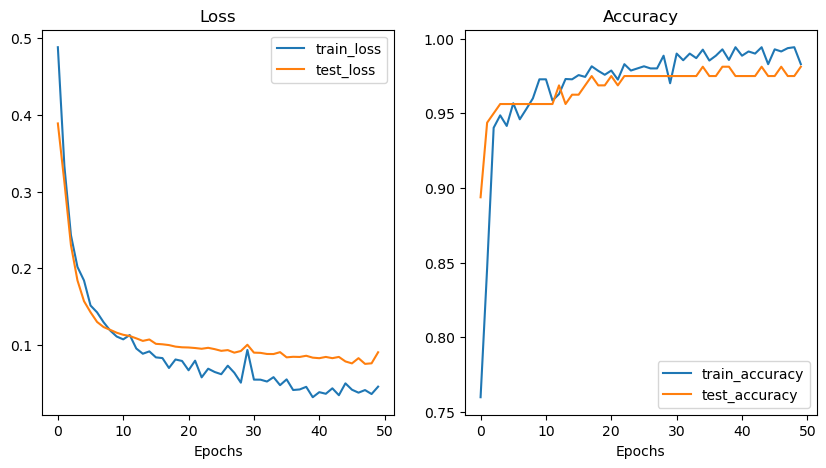

In [48]:
plot_results(model_tl_results)

# Model Comparison

Now that all of our models are trained. Let's load the models back with the weights that resulted in the lowest test loss (the validation loss to be exact).

In [49]:
#load the models with the best performing parameters based on validation dataset
resume(baseline, "best_baseline_model.pth")
resume(model_1, "best_model_1.pth")
resume(model_tl, "best_model_tl.pth")

Previously, we reserved another seperate testing dataset during `random_split`. Although the validation dataset already gave us a pretty good idea of how the models perform on unseen data, let's double check and evaluate the models' performance on a final unseen testing dataset.

Let's define the function to evaluate our models' prediction.

In [50]:
def evaluation(model, test_dataloader, loss_fn):

    ###Testing Loop
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():

        for batch, (X, y) in enumerate(test_dataloader):

            X, y = X.to(device), torch.unsqueeze(y, dim=1).float().to(device)

            test_logits = model(X)
            test_pred = torch.round(torch.sigmoid(test_logits))

            loss = loss_fn(test_logits, y)
            test_loss += loss.item()

            #calculate and accumulate accuracy
            acc = (test_pred == y).sum().item()/len(y)
            test_acc += acc
            
    #calculate the average loss and average acc by batch (in one epoch)
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    print(f"Model achieved an accuracy of {test_acc*100: .4f}% and an average loss of {test_loss: .4f}")
    return test_loss, test_acc

Before we feed the testing dataset into the `evaluation` function, remember that we also have to set them up and apply data transformation so they can be read properly by the model.

In [51]:
test_dataset_transformed = MySubset(test_dataset, transform=data_transform)
test_dataset_tl_transformed = MySubset(test_dataset_tl, transform=auto_transforms)

test_loader = DataLoader(test_dataset_transformed, shuffle=False)
test_loader_tl = DataLoader(test_dataset_tl_transformed, shuffle=False)

And here are the models' performance on the testing data.

In [52]:
torch.manual_seed(seed)
#predict using baseline
baseline_loss, baseline_acc = evaluation(baseline, test_loader, loss_fn)

Model achieved an accuracy of  89.9329% and an average loss of  0.2274


In [53]:
torch.manual_seed(seed)
#predict using model_1
model_1_loss, model_1_acc = evaluation(model_1, test_loader, loss_fn)

Model achieved an accuracy of  90.6040% and an average loss of  0.2778


In [54]:
torch.manual_seed(seed)
#predict using model_tl
model_tl_loss, model_tl_acc = evaluation(model_tl, test_loader_tl, loss_fn)

Model achieved an accuracy of  97.9866% and an average loss of  0.0442


In [55]:
#group model loss and accuracy into a dataframe
model_comparison_list = [[baseline_loss, baseline_acc], [model_1_loss, model_1_acc], [model_tl_loss, model_tl_acc]]
model_comparison_df = pd.DataFrame(model_comparison_list, columns=["loss", "accuracy"], index=["baseline", "model_1", "model_tl"])
model_comparison_df

loss  accuracy
baseline  0.227392  0.899329
model_1   0.277800  0.906040
model_tl  0.044201  0.979866

<Axes: xlabel='None', ylabel='accuracy'>

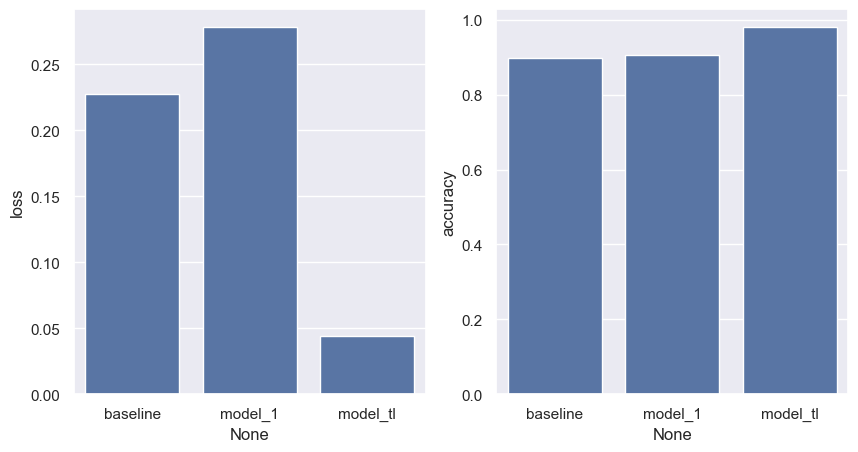

In [56]:
sns.set(rc={'figure.figsize':(10,5)})
fig, ax = plt.subplots(1, 2)

#plot loss and accuracy for model_comparison
sns.barplot(data=model_comparison_df, x=model_comparison_df.index, y="loss", ax=ax[0])
sns.barplot(data=model_comparison_df, x=model_comparison_df.index, y="accuracy", ax=ax[1])

The results on the testing data are more or less the same as that of the validation data. The last model that utilized transfer learning stands firmly at the top in terms of performance. The accuracy of the first two models are roughly the same, but we can see the loss of *model_1* is even higher than that of the *baseline*. This is a little surprising because the loss of the validation set is actually lower for *model_1* than the *baseline* model. Perhaps, the performances of *baseline* and *model_1* were never significantly different. To see which one is better, we would need a larger dataset to validate their performances with greater certainty.

# Testing on Custom Data

We know for sure that our pretrained model is the best, so let's try and see how our pretrained model performs on some random pictures extracted from the internet. I specifically picked three images from the internet and saved them in the *custom-fire-images* dataset file. Let's define the function that will allow us to predict and plot.

In [57]:
#define function to predict custom images
def pred_and_plot_image(model, image_path, transform, device: torch.device=device):
    
    img = Image.open(image_path)

    image_transform = transform

    model.to(device)
    model.eval()
    with torch.inference_mode():

        transformed_image = image_transform(img).unsqueeze(dim=0)
        target_image_pred = model(transformed_image.to(device))

        target_image_pred_probs = torch.sigmoid(target_image_pred)
        target_image_pred_label = torch.round(target_image_pred_probs)
        
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {target_image_pred_label.cpu().numpy()[0][0]} | Prob: {target_image_pred_probs.cpu().numpy()[0][0]: .3f}")
    plt.axis(False);

## Fire Image

In our first custom *fire image*, we can see that the model was able to accurately predict its class, with certainty, too! The probability is 0.019 which is very close to 0, and so the model is quite certain that this is a fire image.

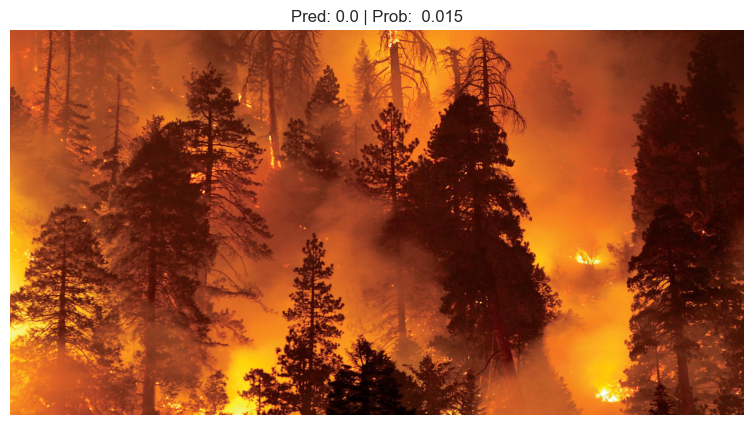

In [58]:
#predict fire image
pred_and_plot_image(model_tl, "../test_images/fire_image.jpg", auto_transforms, device)

## Non-fire Image

Our model was also able to correctly predict the second image. The image is a clear and green forest with no signs of fire at all, and so the model was able to classify this image as *non-fire* with absolute certainty.

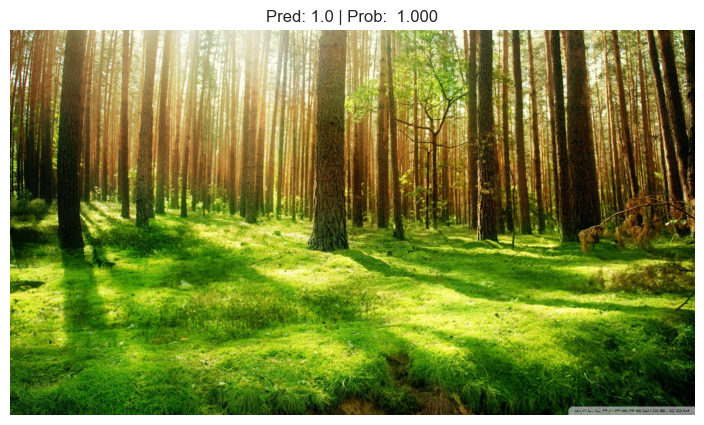

In [59]:
#predict non-fire image
pred_and_plot_image(model_tl, "../test_images/non_fire_image.jpg", auto_transforms, device)

## Tricky Image

Let's making things trickier in the third image. In this picture, it appears as if there are small bushes of fire at the bottom. And to be honest, I'm not even sure if they're really fire or not. This uncertainty is also reflected by our model, which eventually predicts the image as a fire image. But we can see that the the model is also not as certain with a predicted probability of 0.440. 

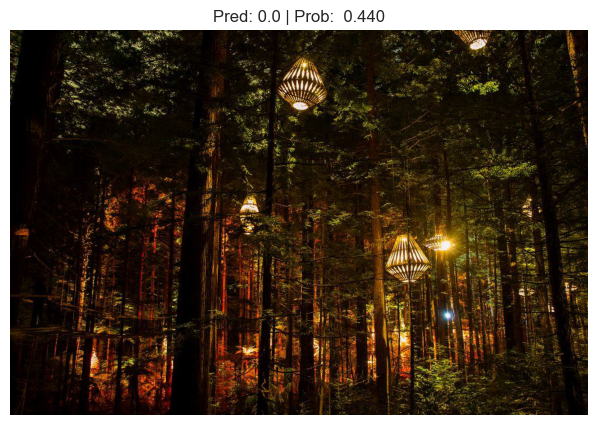

In [60]:
#predict tricky image
pred_and_plot_image(model_tl, "../test_images/tricky_image.jpg", auto_transforms, device)

# Conclusion

Wow! That was a lot of fun! We were able to to build three models to predict fire images, all of which performed pretty well. Our last model using transfer learning even achieved an amazing accuracy of 98%! Hope you found this notebook exciting!